<a href="https://colab.research.google.com/github/TienTranTrung/Paper_CDLMS_code/blob/master/notebooks/Paper_CDLMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install library and import dataset

In [ ]:
# Import and Install Dependencies
!pip install -q numpy timm pretrainedmodels gdown==5.1.0
!gdown --id 1do86HWYyYm9EVBI_grmOcvjNLv3gc2hn
!git clone https://github.com/TienTranTrung/ASL_Rerverse_translate.git
# !pip install -q pretrainedmodels

In [ ]:
!mkdir data
!unzip -q 'Dataset_Banana_stages_ripeness.zip' -d data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import torch
import cv2
import math
import numpy as np
import pandas as pd
import random
import time
import timm
from scipy.ndimage import gaussian_filter, map_coordinates
from scipy.signal import savgol_filter
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset
from torchvision import transforms, models
import torchvision

if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


## Data Augmentation

In [ ]:
def augment_image(original_image, num_augmentations, target_size=(224, 224)):
    augmented_images = []
    erasing_probability=0.5

    # Define augmentation functions
    def rotate_image(image):
        angle = np.random.choice([0, 90, 180, 270])
        M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
        return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    def flip_image(image):
        return cv2.flip(image, np.random.choice([0, 1]))

    def zoom_image(image):
        return cv2.resize(image, None, fx=np.random.choice([1.1, 0.9]), fy=np.random.choice([1.1, 0.9]))

    def shift_image(image):
        shift = np.random.randint(-5, 5)
        M = np.float32([[1, 0, shift], [0, 1, shift]])
        return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    def blur_image(image):
        kernel_size = np.random.choice([3, 5])  # Choose random kernel size for blurring
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    def saturate_image(image):
        # Convert the image to HSV color space
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Define a random saturation factor
        saturation_factor = torch.FloatTensor(1).uniform_(0.8, 1.2)

        # Apply the saturation factor on the saturation channel
        hsv[:, :, 1] = hsv[:, :, 1] * saturation_factor.item()

        # Convert the numpy array to a tensor before clamping
        hsv_tensor = torch.from_numpy(hsv)
        hsv_tensor[:, :, 1] = torch.clamp(hsv_tensor[:, :, 1], 0, 255)

        # Convert the tensor back to a numpy array
        hsv = hsv_tensor.numpy()

        # Convert the image back to BGR color space
        saturated_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        return saturated_image

    def color_jitter(image):
        # Convert the image to HSV color space
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Define random brightness, contrast and saturation factors
        brightness_factor = np.random.uniform(0.8, 1.2)
        contrast_factor = np.random.uniform(0.8, 1.2)
        saturation_factor = np.random.uniform(0.8, 1.2)

        # Apply the factors on the respective channels
        hsv[:, :, 0] = hsv[:, :, 0] * brightness_factor
        hsv[:, :, 1] = hsv[:, :, 1] * contrast_factor
        hsv[:, :, 2] = hsv[:, :, 2] * saturation_factor

        # Convert the numpy array to a tensor before clamping
        hsv_tensor = torch.from_numpy(hsv)
        hsv_tensor = torch.clamp(hsv_tensor, 0, 255)

        # Convert the tensor back to a numpy array
        hsv = hsv_tensor.numpy()

        # Convert the image back to BGR color space
        jittered_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        return jittered_image
    def cutout(image, size=16):
        height, width = image.shape[1:]
        y = np.random.randint(0, height)
        x = np.random.randint(0, width)
        y1 = np.clip(y - size // 2, 0, height)
        y2 = np.clip(y + size // 2, 0, height)
        x1 = np.clip(x - size // 2, 0, width)
        x2 = np.clip(x + size // 2, 0, width)
        image[:, y1:y2, x1:x2] = 0
        return image

    augmentations = [rotate_image, flip_image, zoom_image, shift_image, blur_image, cutout]

    # Randomly apply augmentations
    while len(augmented_images) < num_augmentations:
        augmentation = random.choice(augmentations)
        augmented_image = augmentation(original_image)
        augmented_image = cv2.resize(augmented_image, target_size)
        augmented_images.append(augmented_image)

    return augmented_images[:num_augmentations]

In [ ]:
def balance_classes(dataset, targets, class_counts, desired_image_counts, augment_image, class_names):
    new_data = []
    new_targets = []
    # For each class
    for class_index, class_name in enumerate(class_names):
        # Images in the current class
        class_images = [dataset[i][0] for i, t in enumerate(targets) if t == class_index]
        current_count = class_counts[class_name]
        desired_count = desired_image_counts[class_name]

        # If the current class has fewer images than desired, augment it
        if current_count < desired_count:
            additional_needed = desired_count - current_count
            augmented_images = []
            while len(augmented_images) < additional_needed:
                for image in class_images:
                    if len(augmented_images) < additional_needed:
                        aug_imgs = augment_image(image.numpy().transpose(1, 2, 0), 1)
                        augmented_images.extend(aug_imgs)
                    else:
                        break
            # Add augmented images to the dataset
            new_data.extend(augmented_images)
            new_targets.extend([class_index] * len(augmented_images))

    # Convert new data to Tensors
    new_data_tensors = [torch.tensor(img.transpose(2, 0, 1)) for img in new_data]

    # Update dataset with new images
    dataset.extend(zip(new_data_tensors, new_targets))
    targets.extend(new_targets)

    # Update class counts
    updated_class_counts = {class_name: sum(y == i for y in targets) for i, class_name in enumerate(class_names)}

    return dataset, updated_class_counts


In [ ]:
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

def visualize_images(images, title):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 2))
    for i, img in enumerate(images):
        img = denormalize(img.numpy().transpose(1, 2, 0)) # Denormalize and convert from Tensor image
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

## Spliting dataset

In [ ]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
data_dir = '/content/data/Fayoum_University_Banana _Classes'
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Get the targets before splitting
targets = dataset.targets

# Split the dataset into training and a temporary set
train_data, temp_data, train_targets, temp_targets = train_test_split(dataset, targets, test_size=0.2, random_state=42, stratify=targets)
# Get class names
class_names = dataset.classes

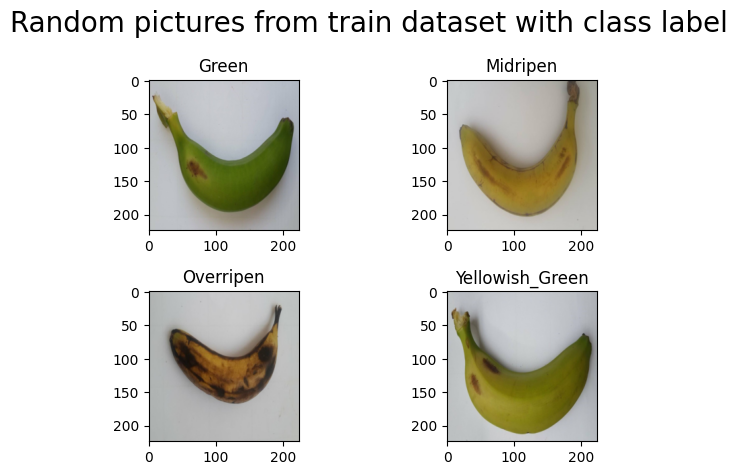

In [ ]:
# Visualize some images before data augmentation
fig, axs = plt.subplots(2, 2)
fig.suptitle('Random pictures from train dataset with class label', fontsize=20)
for i, ax in enumerate(axs.flat):
    # Get a random image from the class
    image, label = next((img, label) for img, label in train_data if label == i)
    # Undo normalization for displaying the image
    image = image * torch.Tensor([0.229, 0.224, 0.225])[:, None, None] + torch.Tensor([0.485, 0.456, 0.406])[:, None, None]
    # Convert tensor to numpy array
    image = image.permute(1, 2, 0).numpy()
    # Display the image
    ax.imshow(image)
    ax.set_title(class_names[i])
plt.tight_layout()
plt.show()


{'Green': 83, 'Midripen': 70, 'Overripen': 27, 'Yellowish_Green': 38}
Original images for class Green:


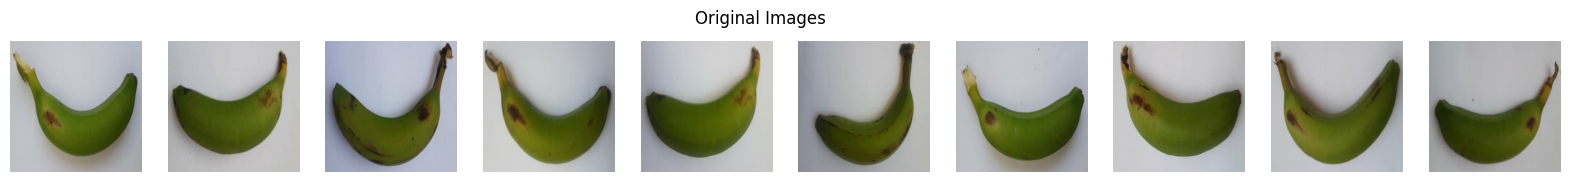

Original images for class Midripen:


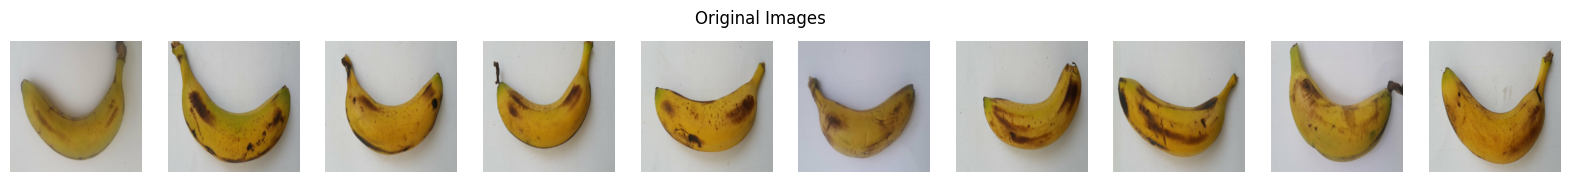

Original images for class Overripen:


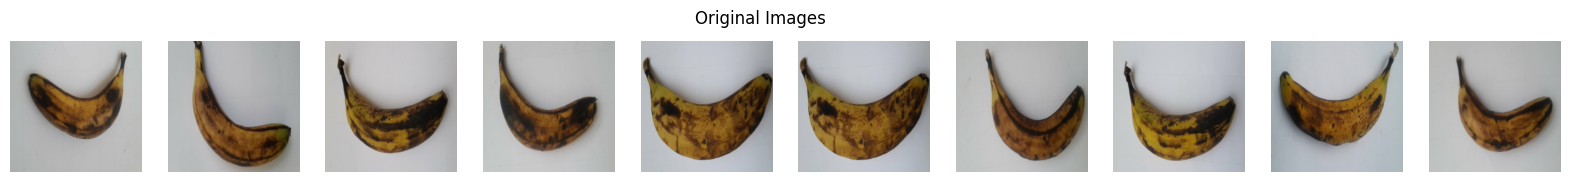

Original images for class Yellowish_Green:


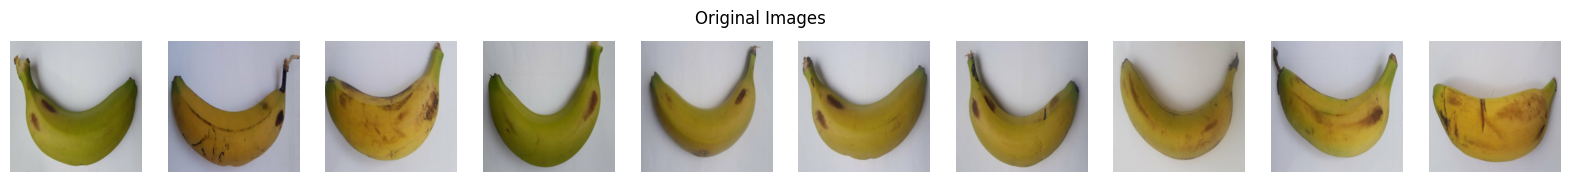

{'Green': 1968, 'Midripen': 1697, 'Overripen': 667, 'Yellowish_Green': 958}
Augmented images for class Green:


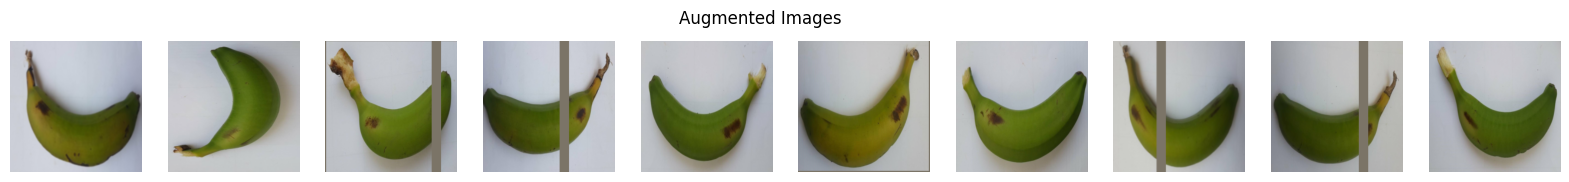

Augmented images for class Midripen:


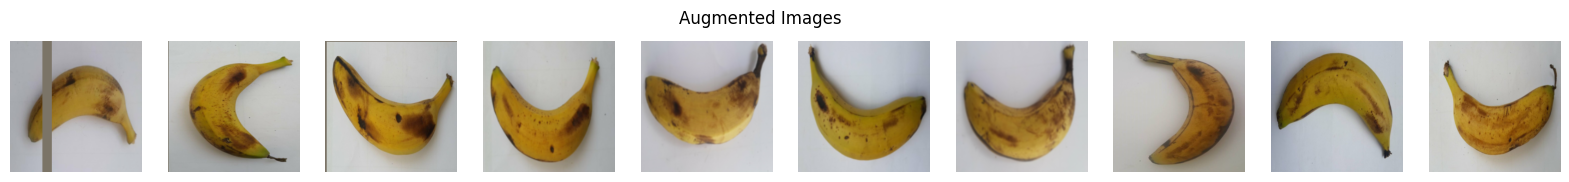

Augmented images for class Overripen:


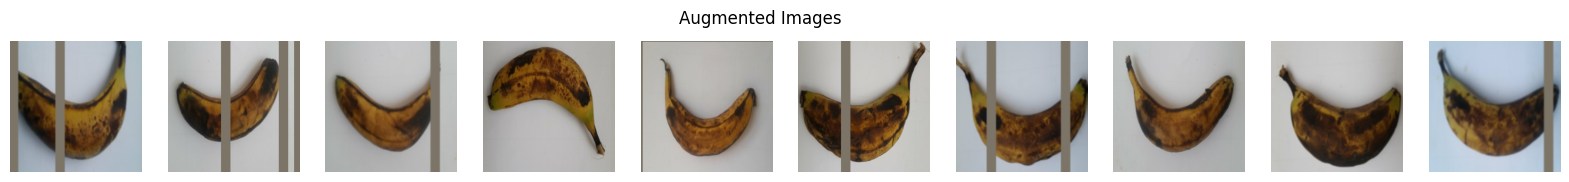

Augmented images for class Yellowish_Green:


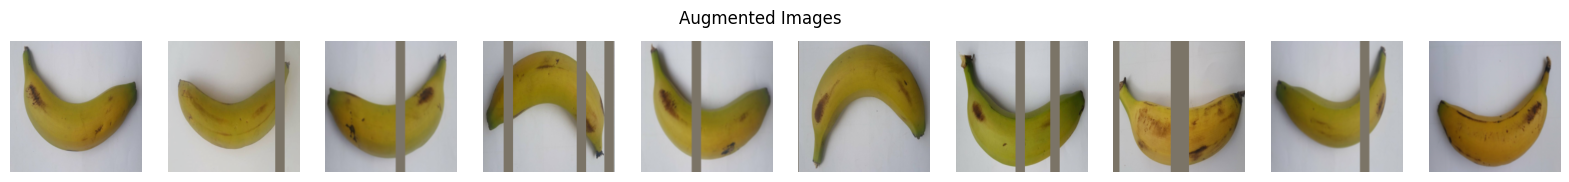

In [ ]:
# Get number of images per class and store original number of images for each ripeness stage
class_counts = {class_name: sum(y == i for y in train_targets) for i, class_name in enumerate(class_names)}
print(class_counts)
# Split the temporary set into validation and test sets
val_data, test_data, val_targets, test_targets = train_test_split(temp_data, temp_targets, test_size=0.5, random_state=42, stratify=temp_targets)

# Dictionary to store the desired number of images for each ripeness stage
desired_image_counts = {'Green': 1968, 'Midripen': 1697, 'Yellowish_Green': 958, 'Overripen': 667}
# desired_image_counts = {'Green': 2000, 'Midripen': 2000, 'Yellowish_Green': 2000, 'Overripen': 2000}

# For each class
for class_index, class_name in enumerate(class_names):
    # Images in the current class before augmentation
    class_images_before = [train_data[i][0] for i, t in enumerate(train_targets) if t == class_index]

    # Visualize original images
    print(f"Original images for class {class_name}:")
    visualize_images(class_images_before[:10], "Original Images")

# Apply data augmentation
train_data, updated_class_counts = balance_classes(train_data, train_targets, class_counts, desired_image_counts, augment_image, class_names)
print(updated_class_counts)

# For each class
for class_index, class_name in enumerate(class_names):
    # Images in the current class after augmentation
    class_images_after = [train_data[i][0] for i, t in enumerate(train_targets) if t == class_index]

    # Visualize augmented images
    print(f"Augmented images for class {class_name}:")
    visualize_images(class_images_after[200:210], "Augmented Images")


In [ ]:
# Create data loaders
batch_size = 32
num_epochs = 50

# Create data loaders for training, validation, and test
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Train and visualize support functions

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        return self.early_stop

In [ ]:
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size,
                               train_time):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle("{} Training | Batch Size: {} | Training Time: {:.2f} minutes".format(model_name, batch_size, train_time / 60), fontsize=16)

    # Smooth lines (optional)
    train_loss_smooth = savgol_filter(train_loss_array, window_length=9, polyorder=3)

    axs[0].plot(train_loss_array, label="Training Loss")
    axs[0].plot(val_loss_array, label="Validation Loss")
    axs[0].set(xlabel='Epoch', ylabel='Loss')
    axs[0].grid(True)

    axs[1].plot(train_acc_array, label="Training Accuracy")
    axs[1].plot(val_acc_array, label="Validation Accuracy")
    axs[1].set(xlabel='Epoch', ylabel='Accuracy')
    axs[1].grid(True)

    axs[0].legend()
    axs[1].legend()
    plt.show()

In [ ]:
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size, train_time):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {} | Training time: {}".format(model_name, batch_size,train_time), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [ ]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader, device='cuda'):
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = copy.deepcopy(model.state_dict())
    train_time_start = time.time()

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch: {epoch + 1}/{num_epochs} | Learning rate: {scheduler.get_lr()[0]}')
        epoch_start_time = time.time()

        # Training phase
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        for samples, targets in train_dataloader:
            samples, targets = samples.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(samples)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * samples.size(0)
            _, preds = torch.max(outputs, 1)
            total_train_correct += torch.sum(preds == targets)
            total_train_samples += samples.size(0)

        train_loss = total_train_loss / total_train_samples
        train_acc = total_train_correct.double() / total_train_samples
        train_loss_array.append(train_loss)
        train_acc_array.append(train_acc.item())

        # Validation phase
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0

        with torch.no_grad():
            for samples, targets in val_dataloader:
                samples, targets = samples.to(device), targets.to(device)
                outputs = model(samples)
                loss = loss_function(outputs, targets)

                total_val_loss += loss.item() * samples.size(0)
                _, preds = torch.max(outputs, 1)
                total_val_correct += torch.sum(preds == targets)
                total_val_samples += samples.size(0)

        val_loss = total_val_loss / total_val_samples
        val_acc = total_val_correct.double() / total_val_samples
        val_loss_array.append(val_loss)
        val_acc_array.append(val_acc.item())

        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'{model_name}_best_weights.pth')
            print(f"New lowest validation loss: {lowest_val_loss:.4f}")

        scheduler.step()

        # Early Stopping check
        if early_stopping(val_loss):
            print("Early stopping triggered")
            break

        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch + 1} completed in {epoch_time:.2f} seconds')

    train_time_total = time.time() - train_time_start
    model.load_state_dict(best_model)
    return model, train_loss_array, train_acc_array, val_loss_array, val_acc_array, train_time_total

In [ ]:
def calculate_metrics(model, dataloader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    y_pred = []
    y_true = []

    with torch.no_grad():  # Deactivate gradients for the following code
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # Get model predictions
            _, preds = torch.max(outputs, 1)  # Get index of the max log-probability

            y_pred.extend(preds.cpu().numpy())  # Append batch predictions
            y_true.extend(labels.cpu().numpy())  # Append batch ground truth labels

    # compute classification report
    classificationReport = classification_report(y_true, y_pred, target_names=class_names)

    print("\nClassification Report:")
    print(classificationReport)

## Training phrase

In [ ]:
# Initialize the ViT model
model_proposed = torchvision.models.vit_b_16(pretrained=True)

model_proposed.head = torch.nn.Linear(in_features=768, out_features=10)

# Freeze the parameters
for param in model_proposed.head.parameters():
    param.requires_grad = True
# Move the model to the device
model_proposed = model_proposed.to(DEVICE)

# Train the model
model_proposed_training_results = training(model=model_proposed,
                                model_name='MobilenetV3_AttentionMechanism',
                                num_epochs=num_epochs,
                                train_dataloader=train_dataloader,
                                val_dataloader=val_dataloader)

# Get the training results
model_proposed, train_loss_array, train_acc_array, val_loss_array, val_acc_array,train_time = model_proposed_training_results

# Get the minimum validation loss and its corresponding epoch and accuracy
min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

actual_num_epochs = len(train_loss_array)
# Visualize the training results
visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           actual_num_epochs,
                           model_name="MobilenetV3_AttentionMechanism",
                           batch_size=8,
                           train_time=train_time)

# Print the training results
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

calculate_metrics(model_proposed, val_dataloader, DEVICE, class_names)

## Testing phrase

In [ ]:
calculate_metrics(model_proposed, test_dataloader, DEVICE, class_names)

## Model Ensemble

In [ ]:
class DynamicMORA(nn.Module):
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(10 * 3, 10)
        self.weight_predictor = nn.Sequential(
            nn.Linear(10 * 3, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.stack((x1, x2, x3), dim=2)  # stack outputs
        weights = self.weight_predictor(x)  # predict weights
        x = (weights * x).sum(dim=2)  # weighted sum
        out = self.classifier(x)
        return out

# Instantiate DynamicMORA with your models
dynamic_mora_model = DynamicMORA(model_deit_v3, model_davit, model_deit)

# Transfer to device
dynamic_mora_model = dynamic_mora_model.to(DEVICE)


In [ ]:
# 4. Push checkpoints to GitHub
!cd code  # Navigate into your cloned repository
!git add checkpoint/
!git commit -m "Updated model checkpoints"
!git push origin master